# Week 8
## Classification
---
- Classification concepts
- Logistic regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from scipy.stats import norm
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')

%matplotlib inline

## Recall: Machine (or Statistical) Learning
---
- Learning structure and relationships in data
- Supervised learning
  - Goal is predicting outputs based on inputs
  - Learn from labeled exemplar data
  - E.g., regression, classification
- Unsupervised learning
  - Goal is reveal hidden structure in the data
  - Inputs but no labeled outputs
  - E.g., clustering

## Classification
---
In classification, we try to predict a *class label* assigning points to groups.

Our classification training data has the same kinds of inputs as in regression, but the *target* variable is discrete, not continuous.

E.g., the training data might include features about a borrower's financial history, credit score, owning/renting history, etc.  The target might be an indicator on whether or not the borrower ultimately defaulted on their loan.

The learning task is to find a *classifier* function which will let us predict future defaults given the same information about a potential borrower.


## Example Problem
---
As with regression, we'll start with an artificially generated problem.  Inputs will be points in a 2-D space, and targets will be classes simply labeled as 'a' and 'b'.

In [2]:
# ensure repeatability of this notebook 
# (comment out for new results each run)
np.random.seed(12345)

def f(X):
    return 3 + 0.5 * X - X**2 + 0.15 * X**3

# convenience function for generating samples
def sample(n, fn, limits, sigma):
    width = limits[1] - limits[0]
    height = limits[3] - limits[2]
    x = np.random.random(n) * width + limits[0]
    y = np.random.random(n) * height + limits[2]
    s = y > fn(x)
    p = norm.cdf(np.abs(y - fn(x)), scale = sigma)
    r = np.random.random(n)
    
    def assign(sign, prob, rnum):
        if sign:
            if rnum > prob:
                return 'b'
            else:
                return 'a'
        else:
            if rnum > prob:
                return 'a'
            else:
                return 'b'
        
    c = [assign(s[i], p[i], r[i]) for i in range(n)]
    
    return DataFrame({'x' : x, 'y' : y, 'class' : c})
    

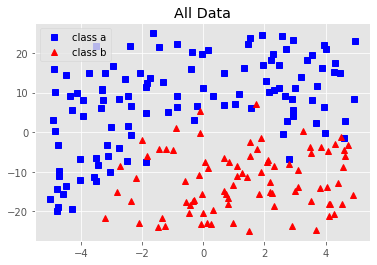

In [3]:
data = sample(200, f, [-5, 5, -25, 25], 5)

dataa = data[data['class']=='a']
datab = data[data['class']=='b']
plt.plot(dataa['x'], dataa['y'],'bs', label='class a')
plt.plot(datab['x'], datab['y'],'r^', label='class b')
plt.legend()
plt.title('All Data')
plt.show()

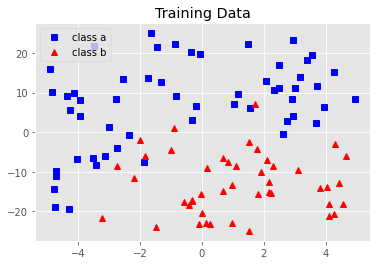

In [4]:
train, test = train_test_split(data, test_size = 0.5)
traina = train[train['class']=='a']
trainb = train[train['class']=='b']
plt.plot(traina['x'], traina['y'],'bs', label='class a')
plt.plot(trainb['x'], trainb['y'],'r^', label='class b')
plt.legend()
plt.title('Training Data')
plt.show()

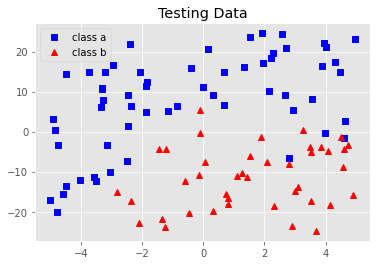

In [5]:
testa = test[test['class']=='a']
testb = test[test['class']=='b']
plt.plot(testa['x'], testa['y'],'bs', label='class a')
plt.plot(testb['x'], testb['y'],'r^', label='class b')
plt.legend()
plt.title('Testing Data')
plt.show()

## *k*-Nearest Neighbor Classification
---
Suppose we get a new point we haven't seen before, class unknown.

What class do we assign it to?

One of the simplest techniques is *k-nearest neighbor* classification.

Simply look at the *k* nearest points and take a majority vote on the class!

Let's try k-nearest neighbor on our example, using scikit-learn:

In [6]:
from sklearn import neighbors
k = 5
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])

KNeighborsClassifier()

Plotting the results is a bit tricky.  Here are a few approaches.

First, we can apply the trained model to the test data, and plot the resulting points.  Correctly classified points will be shown as solid, misclassified points as bordered.  Colors and shapes will match the prediction (not the ground truth).

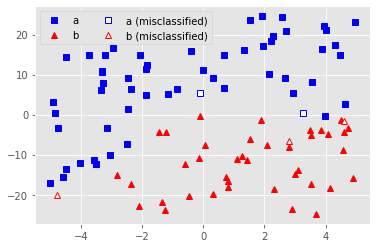

In [7]:
def plot_predicted_1(model, test):
    predicted = model.predict(test[['x','y']])
    correct = test[test['class'] == predicted]
    correcta = correct[correct['class'] == 'a']
    correctb = correct[correct['class'] == 'b']
    incorrect = test[test['class'] != predicted]
    incorrecta = incorrect[incorrect['class'] == 'b']
    incorrectb = incorrect[incorrect['class'] == 'a']
    
    plt.plot(correcta['x'], correcta['y'], 'bs', label='a')
    plt.plot(correctb['x'], correctb['y'], 'r^', label='b')
    plt.plot(incorrecta['x'], incorrecta['y'], 'bs', 
             markerfacecolor='w', label='a (misclassified)')
    plt.plot(incorrectb['x'], incorrectb['y'], 'r^', 
             markerfacecolor='w', label='b (misclassified)')
    plt.legend(loc='upper left', ncol=2, framealpha=1)
    
plot_predicted_1(model, test)

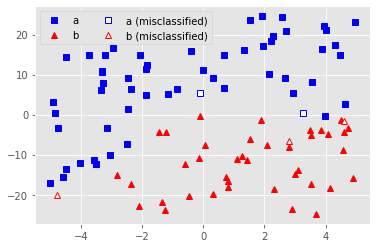

In [8]:
plot_predicted_1(model, test)

One problem with this plot is that it doesn't show us the original training data, so it can be difficult to see where the misclassifications came from.

Another plot, harder to generate, shows us the "decision boundary" - the dividing line between classes.

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


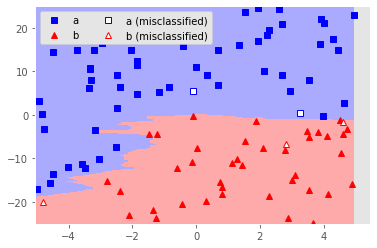

In [9]:
def plot_predicted_2(model, test):
    cmap = ListedColormap(['#AAAAFF','#FFAAAA'])
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array([{'a':0,'b':1}[ab] for ab in pp])
    zz = zz.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plot_predicted_1(model, test)
    
plot_predicted_2(model, test)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


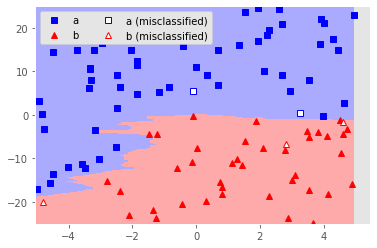

In [10]:
plot_predicted_2(model, test)
plt.show()

Using the functions we wrote above, we can also plot all of the data, or just the training data:

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


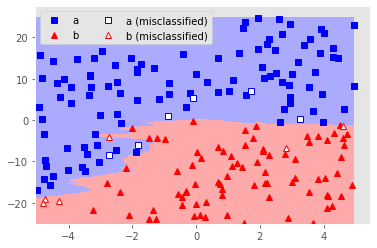

In [11]:
plot_predicted_2(model, data)
plt.show()

## Model Complexity with *k*-Nearest Neighbors
---
Above we used k = 5 to train our model.  As we saw, this gave a fairly smooth decision boundary.

What happens if we decrease or increase *k*?

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


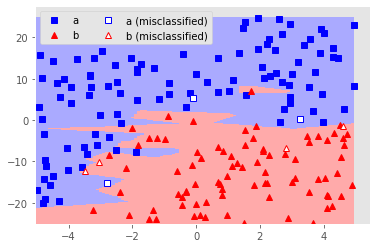

In [12]:
k = 1
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


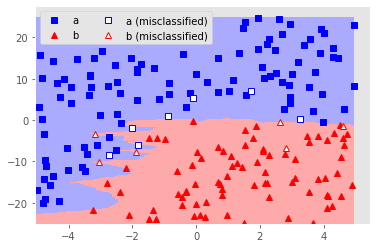

In [13]:
k = 3
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


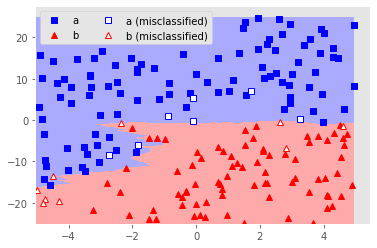

In [14]:
k = 7
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


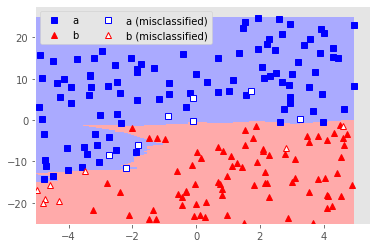

In [15]:
k = 9
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


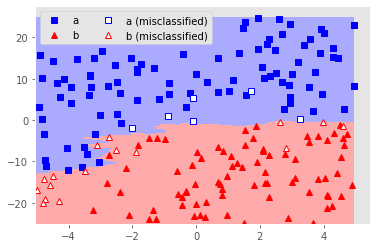

In [16]:
k = 15
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

<ipython-input-9-c2f8454b9559>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


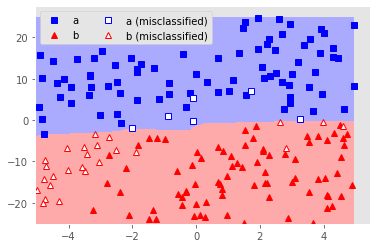

In [17]:
k = 21
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

## Overfitting/Underfitting
---
Just like with regression, classification is sensitive to the complexity of your model.

In *k*-nearest neighbor classification, you overfit by using too few neighbors, and underfit by using too many neighbors.

The scikit-learn nearest neighbor model can generate a score based on the accuracy of our prediction.  Let's see our training and test curves:

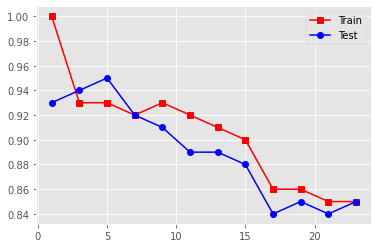

In [18]:
kvals = range(1,25,2)
train_score = []
test_score = []

for k in kvals:
    model = neighbors.KNeighborsClassifier(k)
    model.fit(train[['x','y']], train['class'])
    train_score.append(model.score(train[['x','y']], train['class']))
    test_score.append(model.score(test[['x','y']], test['class']))
    
plt.plot(kvals, train_score, 'r-s', label='Train')
plt.plot(kvals, test_score, 'b-o', label='Test')
plt.legend()
plt.show()

## Proximity Metric p

#### Distance is used to quantify similarity between data points

#### The more distant, the less similar

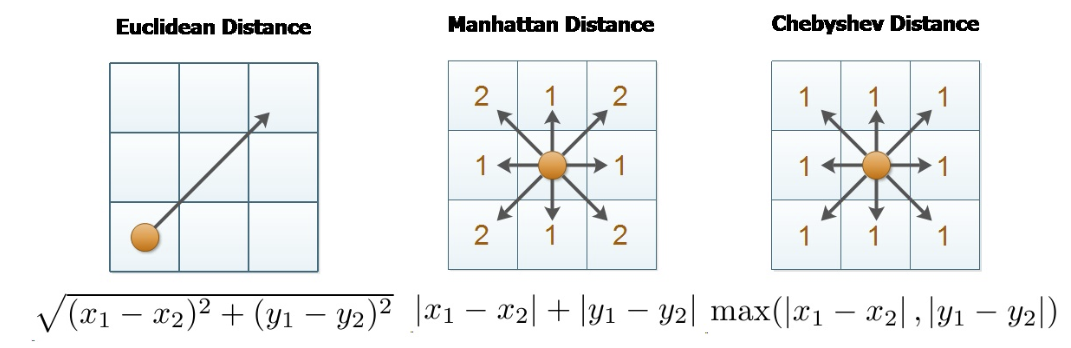

Compared to manhattan distance, Euclidean distance is bigger for larger distances, and smaller for closer data points.

Manhattan distance is sum of absolute distances in each dimension

Manhattan distance generally works only if the points are arranged in the form of a grid and the problem which we are working on gives more priority to the distance between the points only along with the grids, but not the geometric distance.


## Instance-based versus Parametric
---
Instance based methods like *k*-nearest neighbor (KNN), which we used above, *remember* all of the training data, and use it in making new predictions.

We'll study additional instance based methods when we return to regression.

Parametric methods (like ordinary least square linear regression) try to learn a parameterized function, e.g.
$$
\begin{align}
    \hat f(\mathbf{x}) & = 1 w_0 + x_1 w_1 + ... + x_k w_k \\
                   & = \phi \cdot \mathbf{w}
\end{align}
$$

For this lecture we look at parameterized methods for classification.

## Why Not Linear Regression?
---
Our classification problem asks us to determine which of two classes we belong to.

What if we simply turned our two classes into numerical values?

Can we do linear regression on the resulting problem?

First, we expand our DataFrame with a numerical class column:

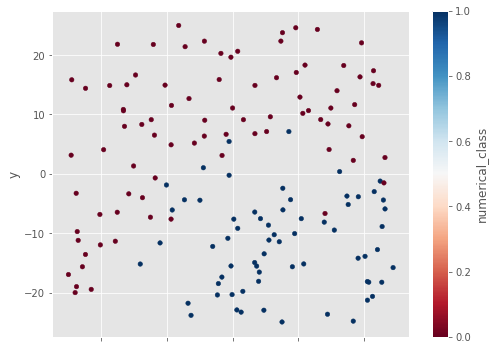

In [19]:
# expand data with numerical class
data['numerical_class'] = 0
data.loc[data['class'] == 'b', 'numerical_class'] = 1
train, test = train_test_split(data)

train.plot(figsize=(8,6), kind='scatter', x='x', y='y',
           c='numerical_class', colormap='RdBu')
plt.show()

Now we train using linear regression:

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train[['x','y']], train['numerical_class'])
plt.figure(figsize=(6,4))
plt.scatter(test['x'], test['y'], 
            c = model.predict(test[['x','y']]), cmap = 'RdBu')
plt.colorbar()
plt.show()

As we can see, this sort of works; our results are no longer discrete values, but we can set a threshold value: say, everything above 0.5 we'll treat as 1, otherwise 0.  Note, though, that some values got set even lower than zero, and some higher than 1, so the scale doesn't provide us good guidance as to where to set the threshold value!

## Logistic Regression
---
Logistic regression takes a slightly different approach. Finds the decision boundary for a binary classification task. 

Rather than modeling the two classes as numbers, it attempts to model the *probability* of belonging in one or the other class.

In logistic regression, we fit the model using the *logistic function*, which has a sigmoid shape:
$$
    p(\mathbf{x})  = \frac{e^{1 w_0 + x_1 w_1 + ... + x_k w_k}}{1 + e^{1 w_0 + x_1 w_1 + ... + x_k w_k}}
$$
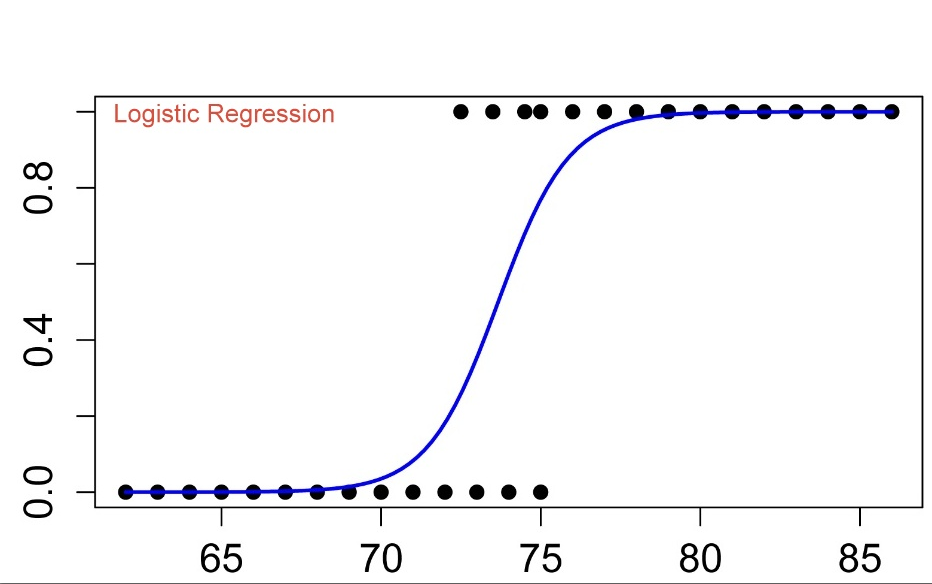
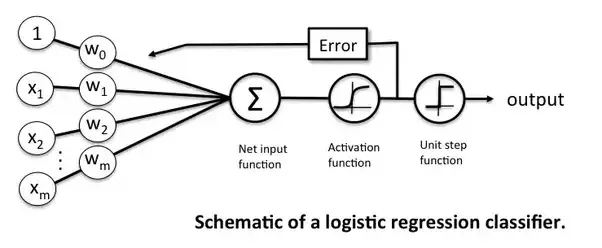

In [49]:
from sklearn import linear_model
#from sklearn.linear_model import LogisticRegression


Large number of features and small number of samples need Linear Models while non-linear models will overfit. 


Dataset that has small size and large dimensionality needs linear models

The technique used to find the fit is called the *maximum likelihood* method, and is beyond the scope of this course.

Fortunately, we can just ask scikit-learn to do the work for us!

In [50]:
### **Step 2:** Choose the function and create an instance of the function
model = linear_model.LogisticRegression()

classifier (can be named anything) is an instance of the LogisticRegression function

Some of the hyperparamters for Logistic regression are Penalty and C
- Penalty removes correlated features

L1 is a strict penalty, L2 is a less strict penalty (the default used if nothing is assigned)<br>
- C

a bigger number of C is used when there a lot of features but not a lot samples with increase in C, penalty will increase, and model becomes simpler

as you progress, you need to optimize the model, 
right now you use a default model

Logistic Regression Model : sigmoid transformation of a linear model b1*x1+b2*x2+I

In [51]:
model.get_params()

# these are hyperparameter

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [52]:
### **Step 3:** Train the Classifier on the Training Dataset

#### Create the model by fitting the function with the training data and the corresponding training labels

model.fit(train[['x','y']], train['class'])

LogisticRegression()

In [53]:
### **Step 4:** Evaluate the Generalization and Memorization performances of the trained Classifier 

# apply model to unseen data
prediction = model.predict(test[['x','y']])
prediction

array(['a', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'a', 'b', 'a',
       'a', 'b', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'a', 'b', 'b',
       'a', 'b', 'b', 'a', 'b', 'a', 'a', 'b', 'a', 'a', 'b', 'b', 'a',
       'a', 'a', 'a', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a'],
      dtype=object)

Using plotting code from last time, we can see the predictions and the mis-classified points.

In [54]:
def plot_predicted_1(model, test):
    predicted = model.predict(test[['x','y']])
    correct = test[test['class'] == predicted]
    correcta = correct[correct['class'] == 'a']
    correctb = correct[correct['class'] == 'b']
    incorrect = test[test['class'] != predicted]
    incorrecta = incorrect[incorrect['class'] == 'b']
    incorrectb = incorrect[incorrect['class'] == 'a']
    
    plt.plot(correcta['x'], correcta['y'], 'bs', label='a')
    plt.plot(correctb['x'], correctb['y'], 'r^', label='b')
    plt.plot(incorrecta['x'], incorrecta['y'], 'bs', markerfacecolor='w', label='a (misclassified)')
    plt.plot(incorrectb['x'], incorrectb['y'], 'r^', markerfacecolor='w', label='b (misclassified)')
    plt.legend(loc='upper left', ncol=2, framealpha=1)

The logistic regression model also yields a *decision function*, which gives back the distance for each point from the dividing hyperplane, yielding a kind of confidence interval:

<ipython-input-55-c32209c4568d>:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


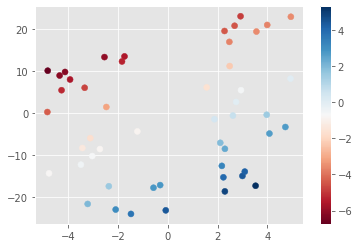

In [55]:
plt.figure(figsize=(6,4))
plt.scatter(test['x'], test['y'], 
            c=model.decision_function(test[['x','y']]), 
            cmap='RdBu')
plt.colorbar()
plt.show()

Also recall that we were estimating class membership probabilities.  We can retrieve these probabilities and plot them, as well.

<ipython-input-56-583336a81e85>:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


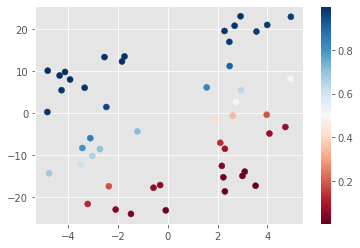

In [56]:
plt.figure(figsize=(6,4))
plt.scatter(test['x'], test['y'], 
            c=model.predict_proba(test[['x','y']])[:,0], 
            cmap='RdBu')
plt.colorbar()
plt.show()

As before, we can visualize the decision boundary by simply plotting all the points in our plane:

<ipython-input-57-5010b9c59a80>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


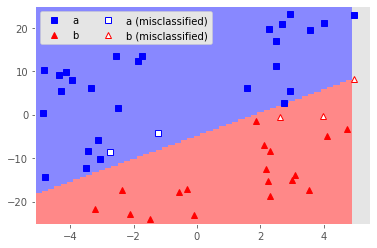

In [57]:
def plot_predicted_2(model, test):
    cmap = ListedColormap(['#8888FF','#FF8888'])
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array([{'a':0,'b':1}[ab] for ab in pp]) 
    zz = zz.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plot_predicted_1(model, test)
plot_predicted_2(model, test)
plt.show()

<ipython-input-57-5010b9c59a80>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)


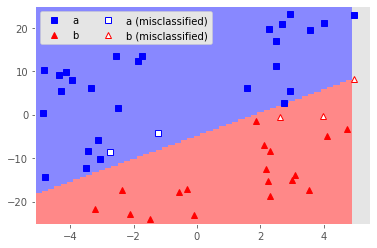

In [58]:
plot_predicted_2(model, test)
plt.show()

We can also plot the probabilities in the plane:

<ipython-input-59-55292281118d>:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)
<ipython-input-59-55292281118d>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


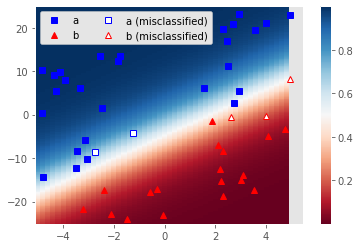

In [59]:
def plot_probabilities(model, test):
    cmap = 'RdBu'
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    zz = pp.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plt.colorbar()
    plot_predicted_1(model, test)

plot_probabilities(model, test)
plt.show()

<ipython-input-59-55292281118d>:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)
<ipython-input-59-55292281118d>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


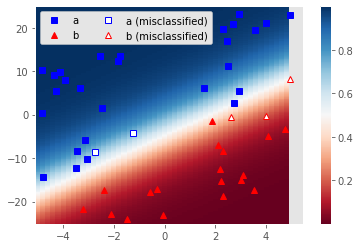

In [60]:
plot_probabilities(model, test)
plt.show()

## Higher Order Logistic Regression
---
As with our linear regression example, we can extend our model using additional *features*, at the possible risk of overfitting.

Let's try a couple of simple polynomial models.

Using sklearn.preprocessing.PolynomialFeatures, we can generate polynomial expansions of our base features to whatever degree desired; however, note that with multiple base features, the size grows very fast!

In our synthetic example, we have x and y input variables.  So a degree-2 polynomial feature set will give us features $(1, x, y, x^2, xy, y^2)$

In [61]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
pf.fit(train[['x','y']])
Phi = pf.transform(train[['x','y']])

In [62]:
model = linear_model.LogisticRegression()
model.fit(Phi, train['class'])

LogisticRegression()

Our plotting function needs a quick revision to handle the PolynomialFeatures setup:

In [63]:
def plot_probabilities_polynomial(model, test, degree):
    pf = PolynomialFeatures(degree=degree)
    cmap = 'RdBu'
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))

    pf.fit(np.c_[xx.ravel(), yy.ravel()])
    pp = model.predict_proba(pf.transform(np.c_[xx.ravel(), yy.ravel()]))[:,0]
    zz = pp.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plt.colorbar()
    
    pf.fit(test[['x','y']])
    predicted = model.predict(pf.transform(test[['x','y']]))
    correct = test[test['class'] == predicted]
    correcta = correct[correct['class'] == 'a']
    correctb = correct[correct['class'] == 'b']
    incorrect = test[test['class'] != predicted]
    incorrecta = incorrect[incorrect['class'] == 'b']
    incorrectb = incorrect[incorrect['class'] == 'a']
    
    plt.plot(correcta['x'], correcta['y'], 'bs', label='a')
    plt.plot(correctb['x'], correctb['y'], 'r^', label='b')
    plt.plot(incorrecta['x'], incorrecta['y'], 'bs', markerfacecolor='w', label='a (misclassified)')
    plt.plot(incorrectb['x'], incorrectb['y'], 'r^', markerfacecolor='w', label='b (misclassified)')
    plt.legend(loc='upper left', ncol=2, framealpha=1)    

<ipython-input-63-b8b3f4cee489>:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)
<ipython-input-63-b8b3f4cee489>:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


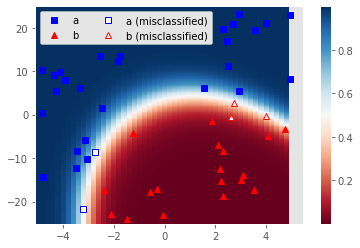

In [64]:
plot_probabilities_polynomial(model, test, 2)
plt.show()

We should also get our score on the test set:

In [65]:
pf.fit(test[['x','y']])
print(model.score(pf.transform(test[['x','y']]), test['class']))
sk.metrics.confusion_matrix(model.predict(pf.transform(test[['x','y']])), test['class'])

0.9


array([[27,  2],
       [ 3, 18]], dtype=int64)

Should we get crazy and try a degree-3 polynomial???

In [66]:
pf = PolynomialFeatures(degree=3)
pf.fit(train[['x','y']])
Phi = pf.transform(train[['x','y']])
model = linear_model.LogisticRegression()
model.fit(Phi, train['class'])

C:\Users\mibra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<ipython-input-63-b8b3f4cee489>:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)
<ipython-input-63-b8b3f4cee489>:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


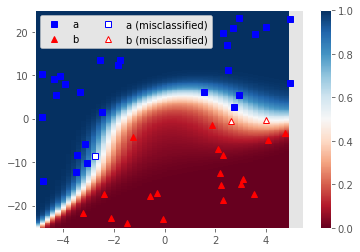

In [67]:
plot_probabilities_polynomial(model, test, 3)

Score:

In [68]:
pf.fit(test[['x','y']])
print(model.score(pf.transform(test[['x','y']]), test['class']))
sk.metrics.confusion_matrix(model.predict(pf.transform(test[['x','y']])), test['class'])

0.94


array([[28,  1],
       [ 2, 19]], dtype=int64)

Should we get really, really crazy and try a degree-4 polynomial???

In [69]:
pf = PolynomialFeatures(degree=4)
pf.fit(train[['x','y']])
Phi = pf.transform(train[['x','y']])
model = linear_model.LogisticRegression()
model.fit(Phi, train['class'])

C:\Users\mibra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<ipython-input-63-b8b3f4cee489>:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap = cmap)
<ipython-input-63-b8b3f4cee489>:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


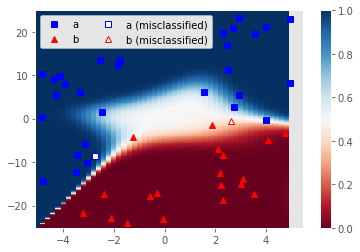

In [70]:
plot_probabilities_polynomial(model, test, 4)

Now we begin to see signs of possible overfitting!

Test score:

In [71]:
pf.fit(test[['x','y']])
print(model.score(pf.transform(test[['x','y']]), test['class']))
sk.metrics.confusion_matrix(model.predict(pf.transform(test[['x','y']])), test['class'])

0.96


array([[29,  1],
       [ 1, 19]], dtype=int64)

**Advantages of Logistic Regression**

- Low computational resources required, easy to train, fast.


- Tuning not required


- Serves as a baseline


- Dont overfit. If the signal to noise ratio is low (it is a ‘hard’ problem) logistic regression is likely to perform best.


- Suitable when number of features is close to number of samples 


- Suitable when there are less training data, high dimensional dataset, and expensive to acquire data


- Interpretable: Gives a measure of how relevant a scaled predictor is (coefficient size) but also its direction of association (positive or negative)


- Features need not be scaled 






**Disadvantages of Logistic Regression**


- Cannot handle non-linear problems


- Feature engineering required to reduce colinearity and remove correlated features


- Feature engineering required to find the most important features


- Does not perform well for large dataset 






**Use**

- Text Classification 


- Risk of developing a given disease (e.g. diabetes; coronary heart disease), based on observed characteristics of the patient (age, sex, body mass index, results of various blood tests, etc.)


**Multiclass Classification Using Binary Classifiers**

1. One vs. All (OvA) or One vs. Rest (OvR)

2. One vs. One (OvO)


#### One vs Rest

One-vs.-rest, OvR or one-vs.-all, OvA or one-against-all, OAA strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. 

#### One vs One

Each classifier receives the samples from a pair of classes, and must learn to distinguish these two classes.

When there are n number of classes, n*(n-1)/2 classifier needs to be trained. 

#### For 0 to 9 digit classification: 


- OvA needs 10 binary classifiers. Each classifier needs to train on the entire dataset. 


- OvO needs 45 binary classifiers. Each classifier needs to train on a portion of the entire dataset. 



> **Question** Which is better OvA or OvO?




OvO is much less sensitive to the problems of imbalanced datasets but is much more computationally expensive.